In [149]:
import cv2
import numpy as np
import math
import scipy
import pandas as pd

In [150]:
df_matrix = pd.DataFrame({
    'matrix': ['1', '2/3', '1/2', '1/2.5', '1/2.7', '1/2.8', '1/3', '1/4'],
    'hor': [13.54, 9.04, 6.77, 5.42, 5.02, 4.84, 4.52, 3.39],
    'vert': [10.16, 6.78, 5.08, 4.06, 3.76, 3.63, 3.39, 2.54]})
df_matrix

,hor,matrix,vert
0,13.54,1,10.16
1,9.04,2/3,6.78
2,6.77,1/2,5.08
3,5.42,1/2.5,4.06
4,5.02,1/2.7,3.76
5,4.84,1/2.8,3.63
6,4.52,1/3,3.39
7,3.39,1/4,2.54


In [151]:
#xl = pd.ExcelFile('camera_resolution.xlsx')
#name=xl.sheet_names[0]
#df = xl.parse(name)
#mp_heigh=df[df['Mp count'] == 8.3]['heigh'].mean()
df_mp = pd.DataFrame({
    'Mp count': [0.02 , 0.08 , 0.1 , 0.2 , 0.4 , 0.6 , 1.0 , 1.3 , 2.0 , 2.1 , 3.1 , 4.0 , 5.0 , 6.0 , 8.3 ],
    'width': [176.0 , 352.0 , 352.0 , 704.0 , 704.0 , 960.0 , 1280.0 , 1280.0 , 1600.0 , 1920.0 , 2048.0 , 2592.0 , 2592.0 , 2736.0 , 3840.0 ],
    'heigh': [120.0 , 240.0 , 288.0 , 240.0 , 480.0 , 576.0 , 720.0 , 960.0 , 1200.0 , 1080.0 , 1536.0 , 1520.0 , 1920.0 , 2192.0 , 2160.0]})
df_mp

,Mp count,heigh,width
0,0.02,120.0,176.0
1,0.08,240.0,352.0
2,0.10,288.0,352.0
3,0.20,240.0,704.0
4,0.40,480.0,704.0
5,0.60,576.0,960.0
6,1.00,720.0,1280.0
7,1.30,960.0,1280.0
8,2.00,1200.0,1600.0
9,2.10,1080.0,1920.0


In [152]:
#функция расстояния между точками координат
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [153]:
#задаваемые параметры
matrix='1/3'
Mp=8.3
h=10
res_opt=25 #разрешение (пиксель/метр) для обнаружения

#основные переменные
matrix_hor=df_matrix[df_matrix['matrix'] == matrix]['hor'].mean()
matrix_vert=df_matrix[df_matrix['matrix'] == matrix]['vert'].mean()
mp_heigh=df_mp[df_mp['Mp count'] == Mp]['heigh'].mean()

zone_length=haversine(31.271574, 58.522488, 31.269112, 58.523040)*1000
focal_lenght=res_opt*matrix_hor*zone_length/mp_heigh


hor_angle=2*np.arctan(matrix_hor/(2*focal_lenght))
vert_angel=2*np.arctan(matrix_vert/(2*focal_lenght))
zone_width=matrix_hor*zone_length/focal_lenght

tau=np.arctan(zone_length/h)-vert_angel/2 #угол поворота камеры
r=h*np.tan(np.arctan(zone_length/h)-vert_angel)
a=(h*np.tan(np.arctan(zone_length/h)-vert_angel))*zone_width/zone_length

print('фокусное расстояние для распознавания на горизонте: ',focal_lenght)
print('горизонтальный и вертикальный углы обзора камеры: ',hor_angle*57.2958,' и ',vert_angel*57.2958)
print('длина зоны обзора: ',zone_length)
print('ширина зоны обзора на горизонте: ', zone_width)
print('ширина фронтовой зоны обзора: ', a)
print('длина слепой зоны: ',r)
print('угол установки камеры: ', tau*57.2958)


фокусное расстояние для распознавания на горизонте:  8.13851568424
горизонтальный и вертикальный углы обзора камеры:  31.0390984769  и  23.5295137292
длина зоны обзора:  155.56808741554195
ширина зоны обзора на горизонте:  86.4
ширина фронтовой зоны обзора:  10.8031458136
длина слепой зоны:  19.4516751422
угол установки камеры:  74.557330768


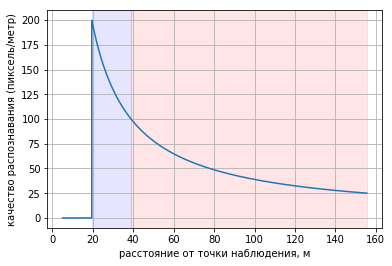

In [154]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

x_100=mp_heigh*focal_lenght/(100*matrix_hor)
x_250=mp_heigh*focal_lenght/(250*matrix_hor)

def func (x,f):
    f_width=matrix_hor*x/f
    if x>r:
        return mp_heigh/f_width
    return 0

# Интервал изменения переменной по оси X
xmin = 5
xmax = zone_length

# Шаг между точками
dx = 0.01

# !!! Создадим список координат по оиси X  
xlist = mlab.frange (xmin, xmax, dx)

# Вычислим значение функции в заданных точках
ylist1 = [func (x,focal_lenght) for x in xlist]
#ylist2 = [func (x,4) for x in xlist]

# !!! Нарисуем одномерные графики
plt.plot (xlist, ylist1)
#plt.plot (xlist, ylist2)
plt.grid(True)
plt.xlabel('расстояние от точки наблюдения, м')
plt.ylabel('качество распознавания (пиксель/метр)')
if x_250>r:
    plt.axvspan(r, x_250, color='green', alpha=0.1)
    plt.axvspan(x_250, x_100, color='blue', alpha=0.1)
    plt.axvspan(x_100, xmax, color='red', alpha=0.1)
elif x_100>r:
    plt.axvspan(r, x_100, color='blue', alpha=0.1)
    plt.axvspan(x_100, xmax, color='red', alpha=0.1)
else:
    plt.axvspan(r, xmax, color='red', alpha=0.1)
        
# Покажем окно с нарисованным графиком
plt.show()

#красная зона - обнаружение (25 пикс/метр)
#синяя зона - распознавание(100 пикс/метр)
#зеленая зона - идентификация (250 пикс/метр)

In [155]:
#вычисление максимальной площади
#необходимо прописать ограничивающее условие
from scipy import optimize
def f(h): 
    r=zone_length-h*np.tan(np.arctan(zone_length/h)-vert_angel)
    return 0.5*(zone_length-h*np.tan(np.arctan(zone_length/h)-vert_angel))*(zone_width+zone_width*(h*np.tan(np.arctan(zone_length/h)-vert_angel))/zone_length)
#min_h=scipy.optimize.fmin(lambda h: -f(h), 1)
min_hh=scipy.optimize.minimize_scalar(lambda h: -f(h),  bounds=[2,20], method='bounded')
min_hh

     fun: -6715.0756325588109
 message: 'Solution found.'
    nfev: 31
  status: 0
 success: True
       x: 2.0000059793731557

#Задачи
1) прописать ограничения для всех переменных
2) составить и нарисовать графики зависимости качества от длины зоны распознавания при разных параметрах: фокуса, Мр
3) наприсать функцию: максимум площади при ограничении на качество распознавания 
4) нарисовать все

изымать данные высоты и ширины из таблички типов матриц. Поиск по размеру матрицы или расширению (1 или 1/3) 
http://infotech.com.ua/article/standarty-identifikacii-raspoznavanii-i-detektirovanii-ludei

уравнения
http://www.osc.phys.msu.ru/mediawiki/upload/Khalili/optimize.pdf

про скорость
http://sio.su/down_a4ud_305_def.aspx

про старые камеры и угол от высоты
https://studbooks.net/2353623/tehnika/raschet_obzora_videokamer

про программу, которая все уже делает
https://markevich.by/obuchenie-proektirovaniyu/urok-2-zony-obzora-kamer-videonablyudeniya.html





Разрешение видеокамеры https://rucam-video.ru/baza_znanij/razreshenie-kamer-videonablyudeniya-chto-ehto.html 

все про матрицу, таблица размеров https://ru.wikipedia.org/wiki/Фотоматрица

характеристики популярных камер
https://vt-tech.eu/articles/foto/277-tablitsa-kharakteristik-matrits-tsifrovykh-fotoapparatov.html

калькулятор и таблица матриц https://www.ivtechno.ru/raschet_6

про программы существующие https://algoritm.org/arch/13_1/13_1_3.pdf

Дипломная работа про камеры https://sibsutis.ru/upload/f33/Кобер_ВКР_v5.9.pdf 